### Goal

The goal of this workshop is to show you how you can ask questions from data and look to see what insights you can get from the data you have or go collect or seek the data that may answer your questions to achieve your business objectives. 

This is not exhaustive in all possible things you can do using data exploration and data science but I attempt to get you to think from a business perspective

### Data 

South Korea COVID Data 


### Category

Data Exploration<br>
Understanding what data is saying and what factors will form the basis for a good model, what transformations are needed is the first step in this. 

In [98]:
# Pandas allows you to load data from csv as dataframes, Nice columnar format
import pandas as pd

# This is just to show what a graph or network data structure can do
import networkx as nx

# This library is basic library in python for plotting functionality 
import matplotlib.pyplot as plt 

# instructing the the plots/graphs be show in the notebook 
%matplotlib inline

plt.style.use('ggplot')

# helpful for dealing with date strings
from datetime import datetime

# helpful for wrangling time values
import time

# Numerical python library for a variety of math and matrix operations
import numpy as np

## Loading the Data from a CSV on local 

You can simple upload the data from your local computer on to the jupyter instance by clicking on upload(up arrow) button on the left navigation (3rd icon from left). In this case I uploaded that to a folder called covid-data on this instance

## Other places You can upload data from 
### we can address any of these in future workshops if of interest!!
1. **S3** (you will see this today)
2. RDS
3. Aurora
4. Dynamodb
5. Documentdb
6. using SSH from remote instances etc.

## Methods to Upload the data 
**Several but a few examples below**

1. You can use the boto3 python SDK provided by AWS 
2. You can do data dump into S3 and pull in from there 
3. You can download the data from any of the sources and upload from your local 
4. etc..


**Let's first load the patient info data into a dataframe**

In [99]:
df=pd.read_csv("covid-data/PatientInfo.csv")

In [100]:
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


**Let's get an idea of what kind of columns, data types and non null counts we have**

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


**If you only want to look at the counts of non null values**

In [102]:
df.count()

patient_id            5165
sex                   4043
age                   3785
country               5165
province              5165
city                  5071
infection_case        4246
infected_by           1346
contact_number         791
symptom_onset_date     690
confirmed_date        5162
released_date         1587
deceased_date           66
state                 5165
dtype: int64

## Let's see what kind of insights we can get from just this data 

<span style="color: red;font-size:1.5em;">Question:Let's ask the question how many people are infected by others ?</span><br>
As an organization you may have a product or a service that may help in reducing the infections, may be you sell face masks, may be you have a contact tracing service, may be you provide an estimate to local facilities in planning.

In [103]:
df[~df['infected_by'].isna()].count()['patient_id']

1346

**There are several NaNs in these columns, in pandas language NaN - Not A Number will get in the way doing aggregations and math, so let's replace that with NA - Not Available, a string**

In [104]:
df['infected_by'].fillna("NA", inplace=True)

In [105]:
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NA,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NA,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NA,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


<span style="color: red;font-size:1.5em;">Question:How many people infected more than 4 people? assuming an average family size of 4</span><br>
This may answer the question if the infections are mostly family or more social than that, this can help provide guidance on social events

In [106]:
df_cont=df[df['infected_by']!="NA"]

### A simple use of graph data structure 
**Let's get a visual of what the infection pattern looks like, each center point is a *person* and each line represents an *unique person they infected*.**

But first let's filter data to the subset of people that infected more than 4 other people

In [107]:
df_inf_4=df_cont[df_cont.groupby('infected_by')['patient_id'].transform('count') > 4]

In [108]:
FG = nx.from_pandas_edgelist(df_inf_4, source='infected_by', target='patient_id', edge_attr=True,)

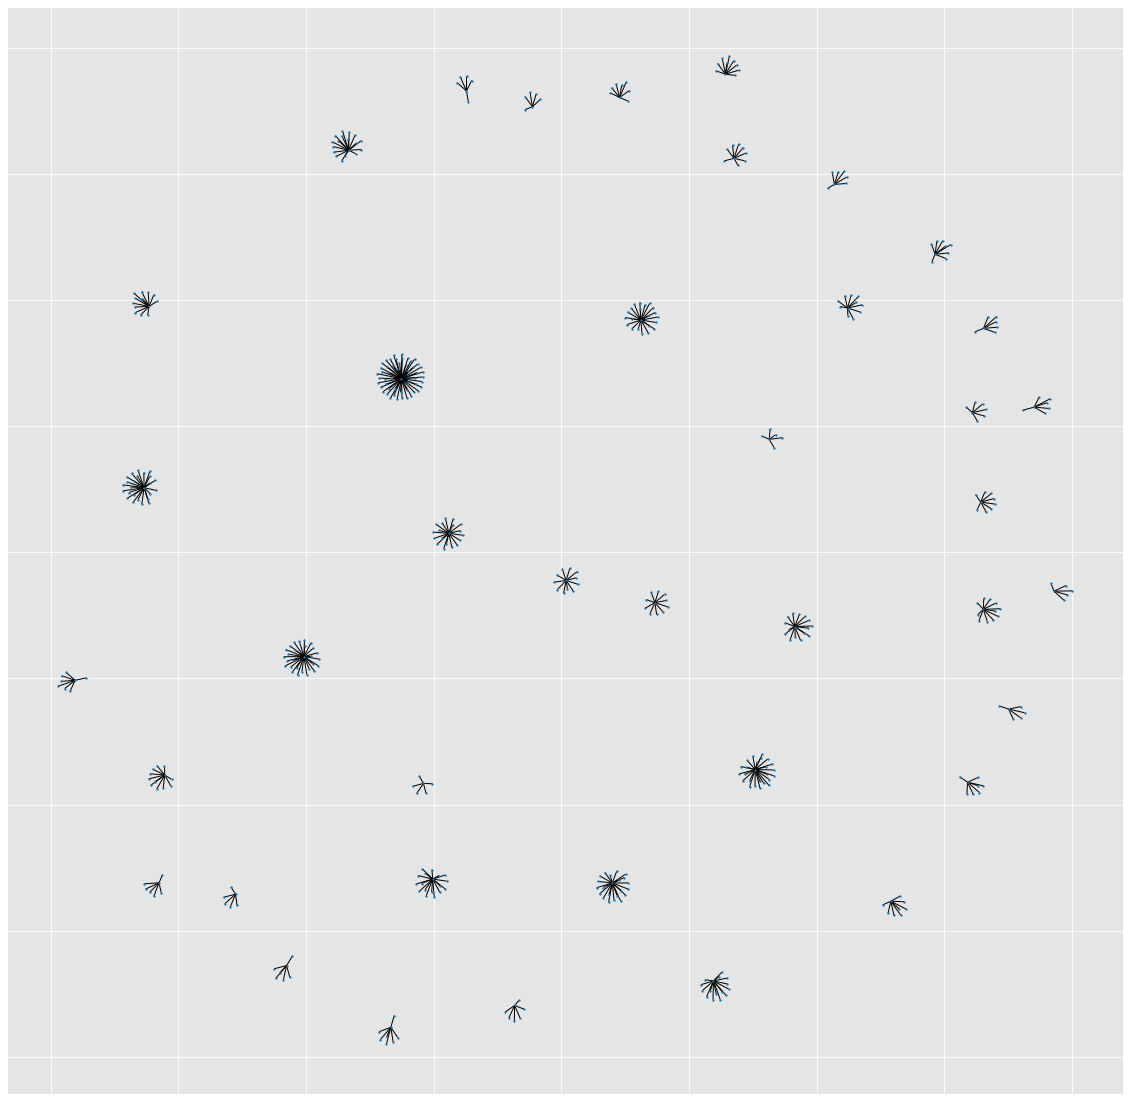

In [109]:
plt.figure(figsize=(20, 20))
# nx.draw(FG, with_labels=False)
nx.draw_networkx(FG, pos=nx.spring_layout(FG, k=0.03),node_size=3, with_labels=False)
# nx.draw_networkx(FG, pos=nx.circular_layout(FG),node_size=3, with_labels=True)

In [110]:
inf_cnt=pd.DataFrame(df_inf_4.groupby('infected_by').count()['patient_id']).reset_index()


### A look at top offenders, Age, Sex, Location

you will notice that contact number(number of people that came in contact) doesn't line up with number of people a person in this list has infected. Possibly contact tracing didn't start till later or wasn't available for some.

In [111]:
df_inf_4.groupby("infected_by").count()['patient_id'].sort_values(ascending=False).head(10)

infected_by
2000000205    51
4100000008    27
1400000209    24
2000000167    24
4100000006    21
2000000309    21
1000000125    18
2000000508    17
1200000031    17
2000001153    15
Name: patient_id, dtype: int64

In [112]:
df[df['patient_id'].isin([2000000205,4100000008,2000000167,1400000209,2000000309,4100000006])]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1852,1400000209,female,NaN,Korea,Incheon,Bupyeong-gu,contact with patient,NA,NaN,NaN,2020-05-31,NaN,NaN,isolated
2379,2000000167,female,40s,Korea,Gyeonggi-do,Bucheon-si,contact with patient,1000000125,NaN,NaN,2020-03-10,NaN,NaN,isolated
2417,2000000205,female,70s,Korea,Gyeonggi-do,Seongnam-si,contact with patient,1000000138,8,NaN,2020-03-14,NaN,NaN,isolated
2521,2000000309,female,80s,Korea,Gyeonggi-do,Gunpo-si,etc,NA,NaN,2020-03-18,2020-03-19,NaN,NaN,isolated
3544,4100000006,female,40s,Korea,Chungcheongnam-do,Asan-si,contact with patient,4100000007,41,2020-02-22,2020-02-26,2020-03-22,NaN,released
3546,4100000008,female,40s,Korea,Chungcheongnam-do,Cheonan-si,gym facility in Cheonan,NA,130,2020-02-20,2020-02-26,2020-03-29,NaN,released


In [113]:
inf_cnt;

<span style="color: red;font-size:1.5em;">Question:What is the distribution of infection by age ?</span><br>

Is this conclusive ? meaning does it gives us full picture , what other questions should we be asking here ?

In [114]:
df['age'].fillna("NA", inplace=True)

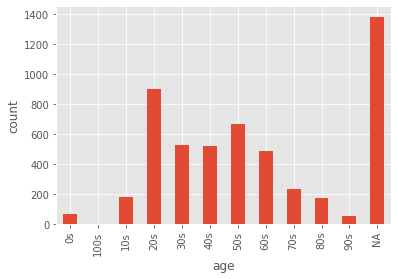

In [115]:
df.groupby('age').count()['patient_id'].plot(kind='bar')
plt.ylabel('count');

<span style="color: red;font-size:1.5em;">Question:What about Gender ?</span><br>
Why is the trend that way ? is it population distribution or is it profession based 

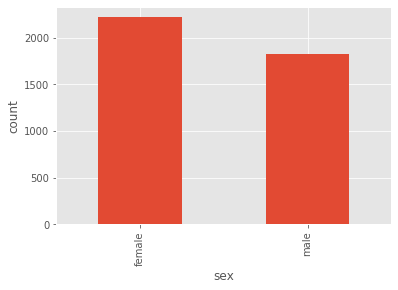

In [116]:
df.groupby('sex').count()['patient_id'].plot(kind='bar')
plt.ylabel('count');

<span style="color: purple;font-size:1.2em; font-weight:bold;"><br>Let's look at the same thing as a proportion</span><br>
Take a notice of the amount of manipulation to get that to work directly as pandas.plot
as an alternative, research how you can plot the same thing as matplotlib bar using x and y series

In [117]:
df['sex'].fillna("NA", inplace=True)

In [118]:
gender_cnts=pd.DataFrame(df.groupby('sex').count()['patient_id']/len(df))

In [119]:
gender_cnts=pd.DataFrame(gender_cnts.unstack()).reset_index()

In [120]:
gender_cnts.columns=['orig_col', 'gender', 'counts']

In [121]:
gender_cnts.head()

,orig_col,gender,counts
0,patient_id,NA,0.217231
1,patient_id,female,0.429429
2,patient_id,male,0.353340


In [122]:
pivot_df = gender_cnts.pivot(index='orig_col', columns='gender', values='counts')

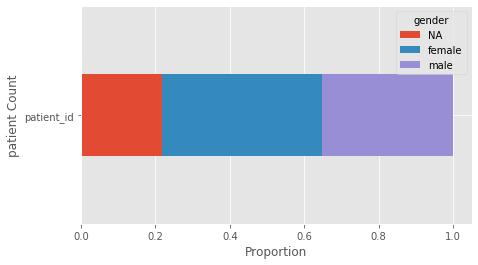

In [123]:
pivot_df.plot.barh(stacked=True, figsize=(7,4), width=0.3)
plt.xlabel("Proportion")
plt.ylabel("patient Count");

**There is a column called state, without scroliing through whole csv, what unique values does this table have ?**

In [124]:
df['state'].unique()

array(['released', 'deceased', 'isolated'], dtype=object)

**It makes sense to ask what percent of people that are infected fall into each of these categories?**

In [125]:
state_cnts=pd.DataFrame(df.groupby('state').count()['patient_id']/len(df))
state_cnts=pd.DataFrame(state_cnts.unstack()).reset_index()
state_cnts.columns=['orig_col', 'state', 'counts']

In [126]:
state_pivot_df = state_cnts.pivot(index='orig_col', columns='state', values='counts')

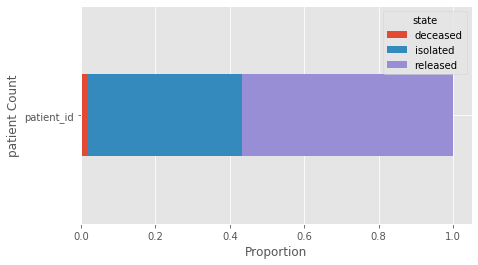

In [127]:
state_pivot_df.plot.barh(stacked=True, figsize=(7,4), width=0.3)
plt.xlabel("Proportion")
plt.ylabel("patient Count");

<span style="color: red;font-size:1.5em;">Question:What sort of time frames exist from symptom onset to final state</span><br>

How soon are patients getting care and how long is it taking to get out of the hospitals ?

In [128]:
df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NA,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NA,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NA,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [134]:
df['symptom_onset_date'].fillna("", inplace=True)
df['confirmed_date'].fillna("", inplace=True)
df['released_date'].fillna("", inplace=True)

In [155]:
def getDaysBetween(date1, date2):
    '''
    date1: datestring in format YYYY-MM-DD
    date2: datestring in format YYYY-MM-DD
    date2>date1
    returns: int (num dates between the two days)
    '''
    if date1=='' or date2=='':
        return None
    else:
        try:
            date1=datetime.strptime(date1, "%Y-%m-%d")
            date2=datetime.strptime(date2, "%Y-%m-%d")
            deltaDates=date2-date1
            return int(deltaDates.days)
        except:
            return None


In [156]:
df['symptom_to_confirm']=df[['symptom_onset_date', 'confirmed_date']].apply(lambda x: getDaysBetween(x['symptom_onset_date'], x['confirmed_date']), axis=1)

In [157]:
df['confirm_to_release']=df[['confirmed_date', 'released_date']].apply(lambda x: getDaysBetween(x['confirmed_date'], x['released_date']), axis=1)

In [161]:
df['symp_to_conf_bins'] = pd.cut(df['symptom_to_confirm'], [0, 5, 10,14, 20, 100])

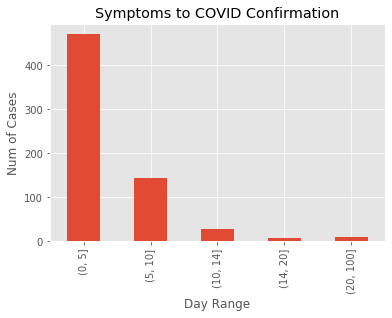

In [166]:
df.groupby('symp_to_conf_bins').count()['patient_id'].plot(kind='bar');
plt.xlabel("Day Range")
plt.ylabel("Num of Cases");
plt.title("Symptoms to COVID Confirmation");

In [170]:
df['conf_to_rel_bins'] = pd.cut(df['confirm_to_release'], [0, 14, 21,28, 35, 50, 100])

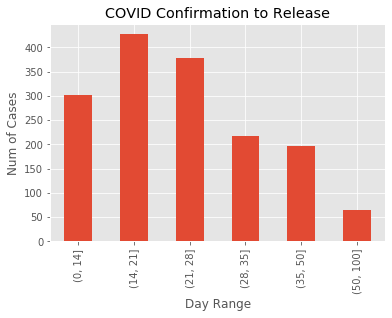

In [171]:
df.groupby('conf_to_rel_bins').count()['patient_id'].plot(kind='bar');
plt.xlabel("Day Range")
plt.ylabel("Num of Cases");
plt.title("COVID Confirmation to Release");